In [1]:
from SalesDataLoader import SalesDataLoader
from SalesDataLoader import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import root_mean_squared_error
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb
import optuna

/Users/luisgrewe/Documents/StockSalesPrediction/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_loader = SalesDataLoader(train_path='data/df_stock_sales_train.xlsx', test_path='data/df_stock_sales_test.xlsx', 
                 date_col='week', target_col='sales', 
                 id_cols=['store_number', 'product_number'])
df = data_loader.load_raw_data()

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_13297/381161796.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nan_counts.index, y=nan_counts.values, palette="viridis")


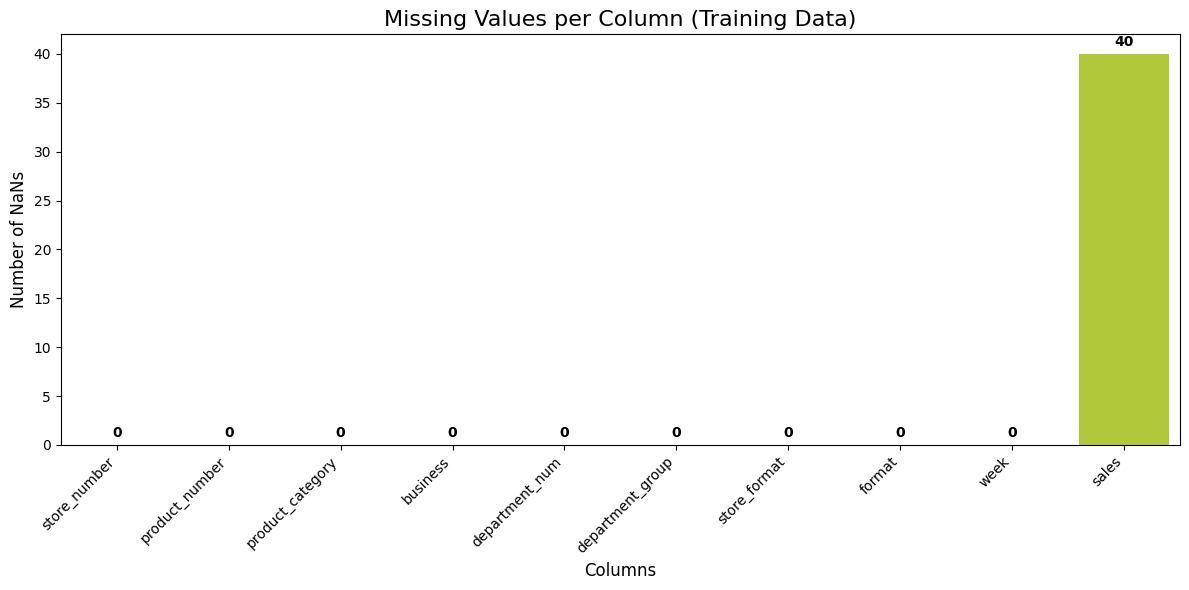

In [3]:
nan_counts = df["train"].isna().sum()

# 2. Create the plot
plt.figure(figsize=(12, 6))
# We use a barplot to show the count per column
sns.barplot(x=nan_counts.index, y=nan_counts.values, palette="viridis")

# 3. Add titles and labels
plt.title("Missing Values per Column (Training Data)", fontsize=16)
plt.ylabel("Number of NaNs", fontsize=12)
plt.xlabel("Columns", fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels so they don't overlap

# Optional: Add the actual number on top of each bar
for i, val in enumerate(nan_counts.values):
    plt.text(i, val + 0.5, str(val), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

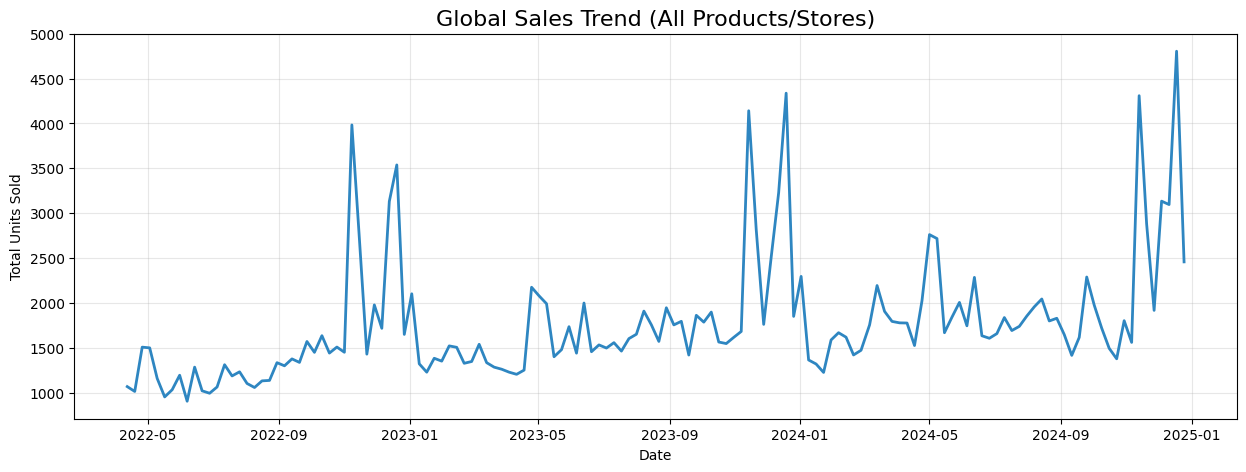

In [4]:
# Aggregate sales by week for all stores
global_trend = df["train"].groupby('week')['sales'].sum().reset_index()

plt.figure(figsize=(15, 5))
plt.plot(global_trend['week'], global_trend['sales'], color='#2E86C1', linewidth=2)
plt.title('Global Sales Trend (All Products/Stores)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total Units Sold')
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
date_distribution = df['train']['week'].value_counts().sort_index()

print(f"Minimum Rows in one week: {date_distribution.min()}")
print(f"Maximum Rows in one week: {date_distribution.max()}")

Minimum Rows in one week: 599
Maximum Rows in one week: 599


## Preprocessing

In [6]:
X_train_preprocessed = data_loader.preprocessing(df['train'])
X_train_preprocessed.dtypes

store_number                 int64
product_number               int64
product_category             int64
business                     int64
department_num               int64
department_group             int64
store_format                 int64
format                       int64
week                datetime64[ns]
sales                      float64
month                        int32
week_of_year                 int64
year                         int32
week_sin                   float64
week_cos                   float64
sales_last_week            float64
dtype: object

In [7]:
"""import pandas as pd

# Assuming X_train_preprocessed is your DataFrame
output_filename = 'preprocessed_train_data.xlsx'

# Save to Excel
# index=False prevents pandas from writing the row numbers as a separate column
X_train_preprocessed.to_excel(output_filename, index=False)

print(f"Data successfully saved to {output_filename}")"""

'import pandas as pd\n\n# Assuming X_train_preprocessed is your DataFrame\noutput_filename = \'preprocessed_train_data.xlsx\'\n\n# Save to Excel\n# index=False prevents pandas from writing the row numbers as a separate column\nX_train_preprocessed.to_excel(output_filename, index=False)\n\nprint(f"Data successfully saved to {output_filename}")'

## Embedding Generation

In [13]:
# 1. Define the parameters using getters
date_col = data_loader.get_date_col()
target = data_loader.get_target_col()

# 2. Define the Cutoff
max_date = X_train_preprocessed[date_col].max()
cutoff_date = max_date - pd.Timedelta(weeks=15)

# 3. Create MASKS
train_mask = X_train_preprocessed[date_col] <= cutoff_date
val_mask = X_train_preprocessed[date_col] > cutoff_date

# 4. Create X and y for Training
# Drop the target and the date column (usually) from X; select only target for y
X_train = X_train_preprocessed.loc[train_mask].drop(columns=[target, "week", "month", "week_of_year"])
y_train = X_train_preprocessed.loc[train_mask, target]

# 5. Create X and y for Validation
X_val = X_train_preprocessed.loc[val_mask].drop(columns=[target, "week", "month", "week_of_year"])
y_val = X_train_preprocessed.loc[val_mask, target]

# 5. Print status
print(f"Train set: {X_train.shape[0]} rows | Date range: {X_train_preprocessed.loc[train_mask, date_col].min().date()} to {cutoff_date.date()}")
print(f"Val set:   {X_val.shape[0]} rows | Date range: {X_train_preprocessed.loc[val_mask, date_col].min().date()} to {max_date.date()}")
print(f"Ready! Training on data up to {cutoff_date.date()}")
X_train.dtypes

Train set: 76073 rows | Date range: 2022-04-12 to 2024-09-11
Val set:   8985 rows | Date range: 2024-09-18 to 2024-12-25
Ready! Training on data up to 2024-09-11


store_number          int64
product_number        int64
product_category      int64
business              int64
department_num        int64
department_group      int64
store_format          int64
format                int64
year                  int32
week_sin            float64
week_cos            float64
sales_last_week     float64
dtype: object

In [14]:
results = {}
categorical_features = [
    'store_number', 'product_number', 'product_category', 
    'business', 'department_num', 'department_group', 
    'store_format', 'format'
]
# --- 1. CatBoost (The current favorite) ---
# It handles categories internally
cat_model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE', # Optimized for your target
    random_seed=42,
    verbose=200
)

cat_model.fit(X_train, y_train, 
              cat_features=categorical_features, 
              eval_set=(X_val, y_val),
              early_stopping_rounds=50)

results['CatBoost'] = root_mean_squared_error(y_val, cat_model.predict(X_val))

# --- 2. XGBoost (The classic powerhouse) ---
# Note: XGBoost needs 'enable_categorical=True' or Label Encoding
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    objective='reg:squarederror',
    enable_categorical=True,
    random_state=42
)

X_train_xgb = X_train.copy()
X_val_xgb = X_val.copy()
for col in categorical_features:
    X_train_xgb[col] = X_train_xgb[col].astype('category')
    X_val_xgb[col] = X_val_xgb[col].astype('category')

xgb_model.fit(X_train_xgb, y_train, 
              eval_set=[(X_val_xgb, y_val)], 
              verbose=200)

results['XGBoost'] = root_mean_squared_error(y_val, xgb_model.predict(X_val_xgb))

# --- 3. LightGBM (The speed king) ---
lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    objective='regression',
    metric='rmse',
    random_state=42
)

lgb_model.fit(X_train_xgb, y_train,
              eval_set=[(X_val_xgb, y_val)],
              callbacks=[lgb.early_stopping(50)])

results['LightGBM'] = root_mean_squared_error(y_val, lgb_model.predict(X_val_xgb))

0:	learn: 9.4657891	test: 15.5312098	best: 15.5312098 (0)	total: 15.2ms	remaining: 30.3s
200:	learn: 4.5019389	test: 8.9131956	best: 8.8619220 (174)	total: 2.4s	remaining: 21.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 8.861921964
bestIteration = 174

Shrink model to first 175 iterations.
[0]	validation_0-rmse:15.45753
[200]	validation_0-rmse:8.81808
[400]	validation_0-rmse:8.83394
[600]	validation_0-rmse:8.84143
[800]	validation_0-rmse:8.89695
[999]	validation_0-rmse:8.93383
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[79]	valid_0's rmse: 9.0228


In [10]:
# Create a clean table of results
res_df = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE']).sort_values('RMSE')
print("--- Model Leaderboard ---")
print(res_df)

winner_name = res_df.index[0]
print(f"\nWinning Model: {winner_name}")

--- Model Leaderboard ---
              RMSE
CatBoost  8.731177
XGBoost   8.833616
LightGBM  9.016435

Winning Model: CatBoost


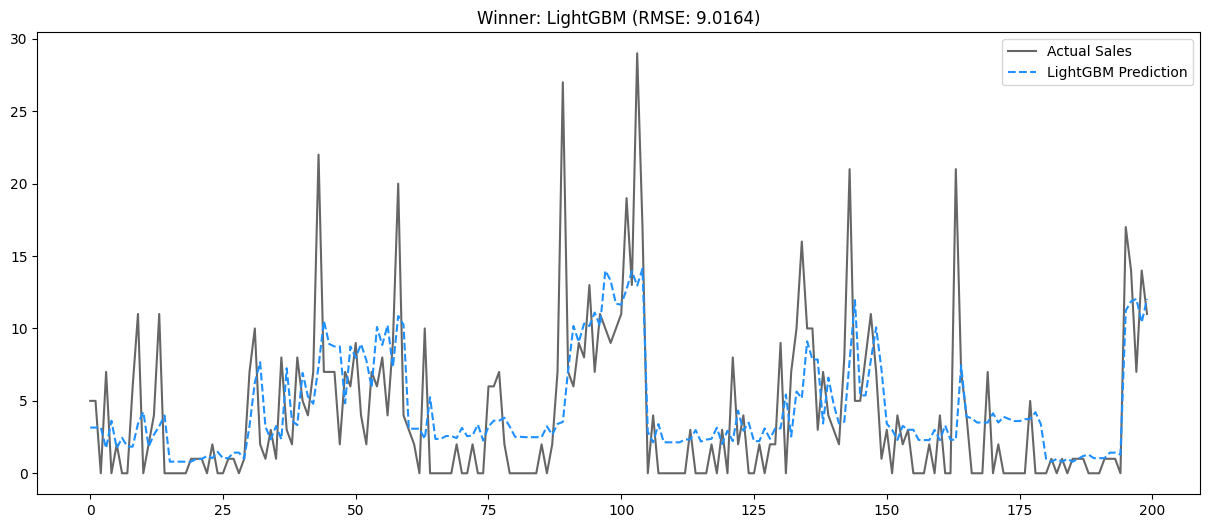

In [11]:
# 1. Generate predictions with the winner
# Note: We use the XGB/LGB prepared data
val_preds = lgb_model.predict(X_val_xgb)

# 2. Plotting
plt.figure(figsize=(15, 6))
plt.plot(y_val.values[:200], label='Actual Sales', color='black', alpha=0.6)
plt.plot(val_preds[:200], label='LightGBM Prediction', color='dodgerblue', linestyle='--')
plt.title(f"Winner: LightGBM (RMSE: {results['LightGBM']:.4f})")
plt.legend()
plt.show()

In [12]:
def objective(trial):
    param = {
        'metric': 'rmse',
        'verbosity': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 10, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    model = lgb.LGBMRegressor(**param)
    model.fit(X_train_xgb, y_train, eval_set=[(X_val_xgb, y_val)], callbacks=[lgb.early_stopping(50)])
    return root_mean_squared_error(y_val, model.predict(X_val_xgb))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2025-12-20 22:34:29,853] A new study created in memory with name: no-name-d4560938-4dc4-4c6a-bedc-67d897ef02fa


Training until validation scores don't improve for 50 rounds


[I 2025-12-20 22:34:30,735] Trial 0 finished with value: 8.978681454532142 and parameters: {'learning_rate': 0.04679000422402249, 'num_leaves': 64, 'min_child_samples': 96}. Best is trial 0 with value: 8.978681454532142.


Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 8.97868
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 22:34:32,442] Trial 1 finished with value: 9.138739417727162 and parameters: {'learning_rate': 0.03332238991606513, 'num_leaves': 136, 'min_child_samples': 83}. Best is trial 0 with value: 8.978681454532142.


Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 9.13874
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 22:34:33,392] Trial 2 finished with value: 10.03197235583922 and parameters: {'learning_rate': 0.014468761422351024, 'num_leaves': 70, 'min_child_samples': 94}. Best is trial 0 with value: 8.978681454532142.


Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 10.032
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 22:34:34,059] Trial 3 finished with value: 8.871147598452765 and parameters: {'learning_rate': 0.08200932978979003, 'num_leaves': 49, 'min_child_samples': 40}. Best is trial 3 with value: 8.871147598452765.


Did not meet early stopping. Best iteration is:
[59]	valid_0's rmse: 8.87115
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 22:34:34,359] Trial 4 finished with value: 8.851016240558799 and parameters: {'learning_rate': 0.08944782471722582, 'num_leaves': 17, 'min_child_samples': 49}. Best is trial 4 with value: 8.851016240558799.


Did not meet early stopping. Best iteration is:
[74]	valid_0's rmse: 8.85102
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 22:34:35,495] Trial 5 finished with value: 9.12360214883512 and parameters: {'learning_rate': 0.034262686754758014, 'num_leaves': 80, 'min_child_samples': 65}. Best is trial 4 with value: 8.851016240558799.


Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 9.1236
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 22:34:36,946] Trial 6 finished with value: 10.198263059682835 and parameters: {'learning_rate': 0.012849540401841926, 'num_leaves': 109, 'min_child_samples': 57}. Best is trial 4 with value: 8.851016240558799.


Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 10.1983
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 22:34:37,878] Trial 7 finished with value: 9.456915741214921 and parameters: {'learning_rate': 0.020636061172790928, 'num_leaves': 66, 'min_child_samples': 90}. Best is trial 4 with value: 8.851016240558799.


Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 9.45692
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 22:34:38,741] Trial 8 finished with value: 8.908702554964806 and parameters: {'learning_rate': 0.04771391103918986, 'num_leaves': 62, 'min_child_samples': 61}. Best is trial 4 with value: 8.851016240558799.


Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 8.9087
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 22:34:39,289] Trial 9 finished with value: 9.062971956602057 and parameters: {'learning_rate': 0.031901374542407664, 'num_leaves': 36, 'min_child_samples': 36}. Best is trial 4 with value: 8.851016240558799.


Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 9.06297
